<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Transformer/Tabular/TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

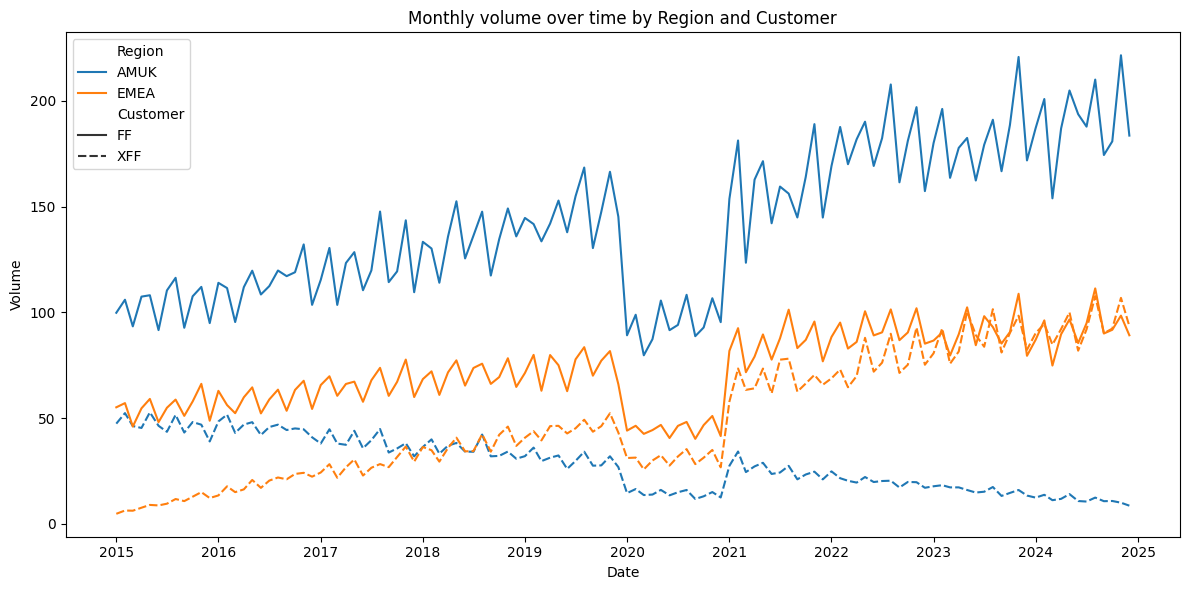

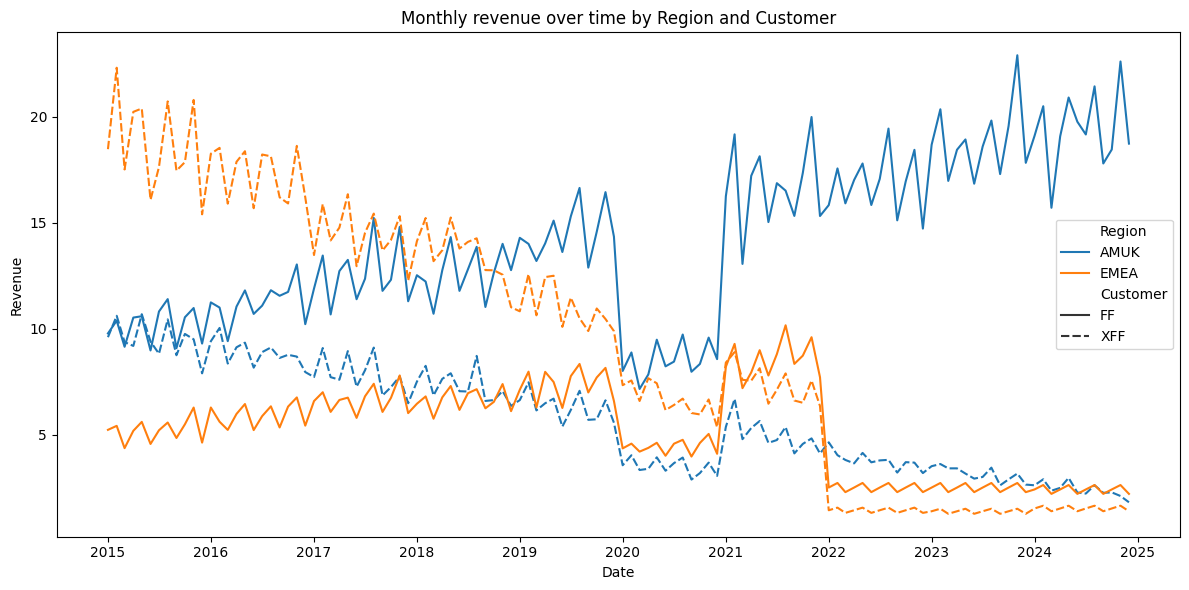

In [1]:
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

regions = ['AMUK', 'EMEA']
customers = ['FF', 'XFF']
features = ['Volume', 'Revenue']

start_date = '2015-01-01'
years = 10
periods = years * 12
time_index = pd.date_range(start=start_date, periods=periods, freq='MS')

def quarterly_seasonality(length, amplitude=0.1):
    t = np.arange(length)
    return 1 + amplitude * np.sin(2 * np.pi * t/3)

def generate_trend(start, end, length, noise=0.05):
    base = np.linspace(start=start, stop=end, num=length)
    return base * (1 + noise * np.random.randn(length))

def flatten_after(date_index, data, flatten_date, flat_level=None):
    flat_start = pd.Timestamp(flatten_date)
    mask = date_index >= flat_start
    if flat_level is None:
        flat_level = data[data_index==flat_start][0] \
            if (date_index==flat_start).any() else data[-1]
    data[mask] = flat_level
    return data

def apply_yearly_shocks(date_index, data):
    data = data.copy()
    years = sorted(set(date_index.year))
    for yr in years:
        mask = date_index.year==yr
        if yr==2020:
            shock = np.random.uniform(low=-0.5, high=-0.3)
        else:
            shock = np.random.uniform(low=-0.05, high=0.05)
        data[mask] *= (1 + shock)
    return data

records = []

for region in regions:
    for customer in customers:
        seasonal = quarterly_seasonality(length=periods)

        if region=='AMUK' and customer=='FF':
            volume = generate_trend(start=100, end=200, length=periods)
            revenue = 0.1 * volume

        elif region=='AMUK' and customer=='XFF':
            volume = generate_trend(start=50, end=10, length=periods)
            revenue = 0.2 * volume

        elif region=='EMEA' and customer=='FF':
            volume = generate_trend(start=50, end=100, length=periods)
            revenue = 0.1 * volume
            revenue = flatten_after(date_index=time_index, data=revenue.copy(),
                flatten_date='2022-01-01',
                flat_level=revenue[time_index.get_loc('2021-12-01')]*0.3)

        elif region=='EMEA' and customer=='XFF':
            volume = generate_trend(start=5, end=100, length=periods)
            revenue = 0.2 * generate_trend(start=100, end=5, length=periods)
            revenue = flatten_after(date_index=time_index, data=revenue.copy(),
                flatten_date='2022-01-01',
                flat_level=revenue[time_index.get_loc('2021-12-01')]*0.2)

        volume *= seasonal
        revenue *= seasonal

        volume = apply_yearly_shocks(date_index=time_index, data=volume)
        revenue = apply_yearly_shocks(date_index=time_index, data=revenue)

        for t, v, r in zip(time_index, volume, revenue):
            records.append([t, region, customer, v, r])

df_history = pd.DataFrame(records,
    columns=['Date', 'Region', 'Customer', 'Volume', 'Revenue'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_history, x='Date', y='Volume', hue='Region', style='Customer')
plt.title('Monthly volume over time by Region and Customer')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_history, x='Date', y='Revenue', hue='Region', style='Customer')
plt.title('Monthly revenue over time by Region and Customer')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn import preprocessing
import pandas as pd

entities = ['Region', 'Customer']
features = ['Volume', 'Revenue']

regions = df_history['Region'].unique()
region2idx = {r: i for i, r in enumerate(regions)}

customers = df_history['Customer'].unique()
customer2idx = {c: i for i, c in enumerate(customers)}

df_scaled = df_history.copy()
scalers = {}
for entity, group in df_history.groupby(by=entities):
    scaler = preprocessing.StandardScaler()
    scaler.fit(X=group[features])
    scalers[entity] = scaler
    df_scaled.loc[group.index, features] = scaler.transform(X=group[features])

df_train = df_scaled[df_scaled['Date'] <= '2023-12-01'].copy()
df_test = df_scaled[df_scaled['Date'] >= '2022-01-01'].copy()

print("df_train shape:", df_train.shape)
print("df_test shape:", df_test.shape)

df_train shape: (432, 5)
df_test shape: (144, 5)


In [ ]:
import os
import torch
torch.manual_seed(seed=42)

class TSDataset(torch.utils.data.Dataset):
    def __init__(self, df, in_len=24, out_len=12):
        self.windows = []

        for (region, customer), group in df.groupby(by=entities):
            region_idx = region2idx[region]
            customer_idx = customer2idx[customer]
            arr = group.sort_values(by='Date')[features].values.astype(np.float32)
            max_start = len(arr) - (in_len + out_len) + 1
            for s in range(max_start):
                x = arr[s : s + in_len]
                y = arr[s + in_len : s + in_len + out_len]
                self.windows.append((region_idx, customer_idx, x, y))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        region, customer, x, y = self.windows[idx]
        return {
            'region': torch.tensor(data=region, dtype=torch.long),
            'customer': torch.tensor(data=customer, dtype=torch.long),
            'x': torch.tensor(data=x, dtype=torch.float32),
            'y': torch.tensor(data=y, dtype=torch.float32)
        }

ds_train = TSDataset(df=df_train)
ds_test = TSDataset(df=df_test)

def collate_fn(batch):
    regions = torch.stack(tensors=[b['region'] for b in batch])
    customers = torch.stack(tensors=[b['customer'] for b in batch])
    x = torch.stack(tensors=[b['x'] for b in batch])
    x = x.permute(1, 0, 2)
    y = torch.stack(tensors=[b['y'] for b in batch])
    y = y.permute(1, 0, 2)
    return regions, customers, x, y

dl_train = torch.utils.data.DataLoader(dataset=ds_train, batch_size=16,
    shuffle=True, collate_fn=collate_fn, num_workers=os.cpu_count())
dl_test = torch.utils.data.DataLoader(dataset=ds_test, batch_size=16,
    shuffle=False, collate_fn=collate_fn, num_workers=os.cpu_count())

print(f"Train batches: %d, Test batches: %d"%(len(dl_train.dataset),
    len(dl_test.dataset)))

Train batches: 292, Test batches: 4


In [ ]:
import torch
torch.manual_seed(seed=42)

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(size=(max_len, d_model))
        position = torch.arange(start=0, end=max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float()
            * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerSeq2Seq(torch.nn.Module):
    def __init__(self, num_regions, num_customers, num_features,
            d_model=32, nhead=4, num_encoder_layers=3, num_decoder_layers=3,
            dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.region_emb = torch.nn.Embedding(num_embeddings=num_regions,
            embedding_dim=2)
        self.customer_emb = torch.nn.Embedding(num_embeddings=num_customers,
            embedding_dim=2)
        self.entity_dim = self.region_emb.embedding_dim + self.customer_emb.embedding_dim

        self.input_proj = torch.nn.Linear(in_features=num_features + self.entity_dim,
            out_features=d_model)
        self.output_proj = torch.nn.Linear(in_features=num_features + self.entity_dim,
            out_features=d_model)
        self.pos_enc = PositionalEncoding(d_model=d_model)

        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
            num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward, dropout=dropout, batch_first=False)

        self.head = torch.nn.Linear(in_features=d_model, out_features=num_features)

    def forward(self, region, customer, src_feats, tgt_feats):
        memory = self.encode(region=region, customer=customer, src_feats=src_feats)
        return self.decode(region=region, customer=customer,
            tgt_feats=tgt_feats, memory=memory)

    def _get_entity_emb(self, region, customer):
        r = self.region_emb(region)
        c = self.customer_emb(customer)
        return torch.cat(tensors=[r, c], dim=-1)

    def encode(self, region, customer, src_feats):
        ent_vec = self._get_entity_emb(region=region, customer=customer)
        ent_expand = ent_vec.unsqueeze(0).expand(src_feats.size(0), -1, -1)
        src = torch.cat(tensors=[src_feats, ent_expand], dim=-1)
        src = self.input_proj(src)
        src = self.pos_enc(src)
        return self.transformer.encoder(src)

    def decode(self, region, customer, tgt_feats, memory):
        ent_vec = self._get_entity_emb(region=region, customer=customer)
        ent_expand = ent_vec.unsqueeze(0).expand(tgt_feats.size(0), -1, -1)
        tgt = torch.cat(tensors=[tgt_feats, ent_expand], dim=-1)
        tgt = self.output_proj(tgt)
        tgt = self.pos_enc(tgt)
        out = self.transformer.decoder(tgt, memory)
        return self.head(out)

    @torch.no_grad()
    def predict(self, region, customer, src_feats, pred_len):
        memory = self.encode(region=region, customer=customer, src_feats=src_feats)
        last_step = src_feats[-1:, :, :]
        cur_input = last_step
        outputs = []
        for _ in range(pred_len):
            pred = self.decode(region=region, customer=customer,
                tgt_feats=cur_input, memory=memory)
            step_pred = pred[-1:, :, :]
            outputs.append(step_pred)
            cur_input = torch.cat(tensors=[cur_input, step_pred], dim=0)
        return torch.cat(tensors=outputs, dim=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerSeq2Seq(num_regions=len(region2idx), num_customers=len(customer2idx),
    num_features=len(features)
).to(device)
print(f"Model total parameters: %d"%(sum(p.numel() for p in model.parameters())))

Model total parameters: 89738


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Training duration: 27.69s


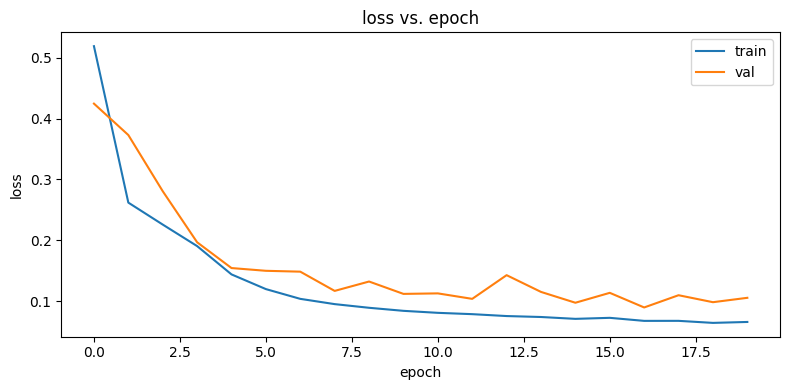

In [ ]:
import torch
torch.manual_seed(seed=42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

def train_step(model, dl_train, criterion, optimizer):
    model.train()
    losses = []
    for region, customer, x, y in dl_train:
        region, customer = region.to(device), customer.to(device)
        x, y = x.to(device), y.to(device)
        decoder_input = torch.cat(tensors=[x[-1:, :, :], y[:-1, :, :]], dim=0)

        optimizer.zero_grad()
        preds = model(region=region, customer=customer, src_feats=x,
            tgt_feats=decoder_input)
        loss = criterion(input=preds, target=y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    losses = np.mean(losses)
    return losses

def test_step(model, dl_test, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for region, customer, x, y in dl_test:
            region, customer = region.to(device), customer.to(device)
            x, y = x.to(device), y.to(device)
            decoder_input = torch.cat(tensors=[x[-1:, :, :], y[:-1, :, :]], dim=0)
            preds = model(region=region, customer=customer, src_feats=x,
                tgt_feats=decoder_input)
            loss = criterion(input=preds, target=y)
            losses.append(loss.item())
    losses = np.mean(losses)
    return losses

def train_model(model, dl_train, dl_val, save_path, epochs=20):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
        mode='min', factor=0.1, patience=3)

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        train_loss = train_step(model=model, dl_train=dl_train, criterion=criterion,
            optimizer=optimizer)
        history['train_loss'].append(train_loss)
        val_loss = test_step(model=model, dl_test=dl_val, criterion=criterion)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(obj=model.state_dict(), f=save_path)

    return model, history

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_history, label='train', x='epoch', y='train_loss')
    sns.lineplot(data=df_history, label='val', x='epoch', y='val_loss')
    plt.legend(loc='best')
    plt.title(label=f'loss vs. epoch')
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss')
    plt.tight_layout()
    plt.show()

save_path = 'model.pth'
start_time = time.time()
model, history = train_model(model=model, dl_train=dl_train, dl_val=dl_test,
    save_path=save_path, epochs=20)
print(f"Training duration: %.2fs"%(time.time() - start_time))
plot_history(history=history)

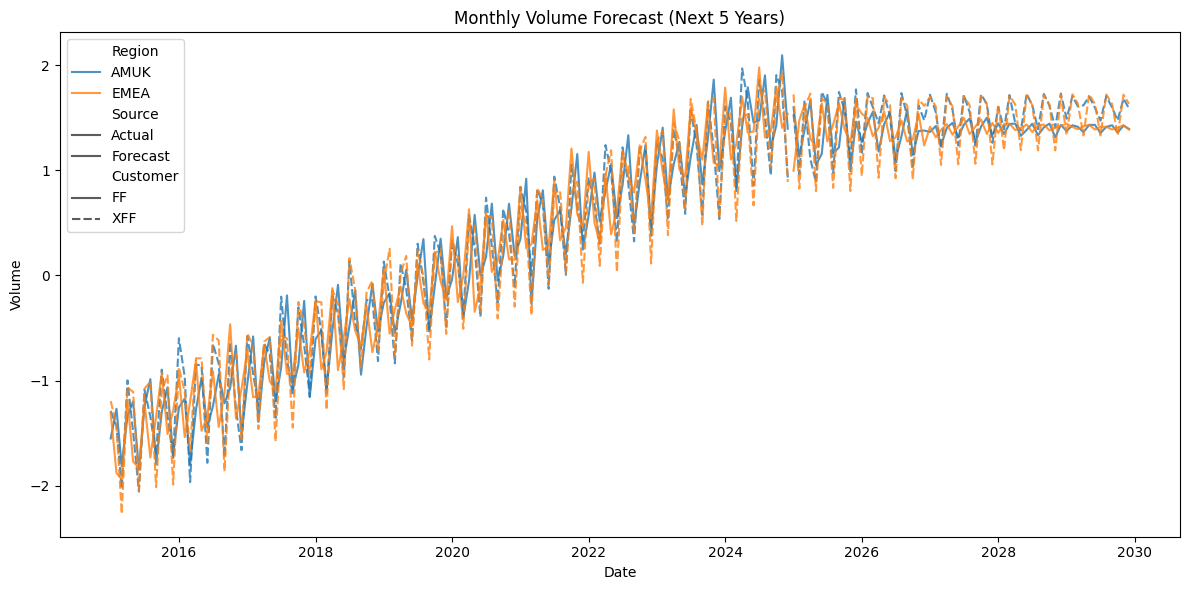

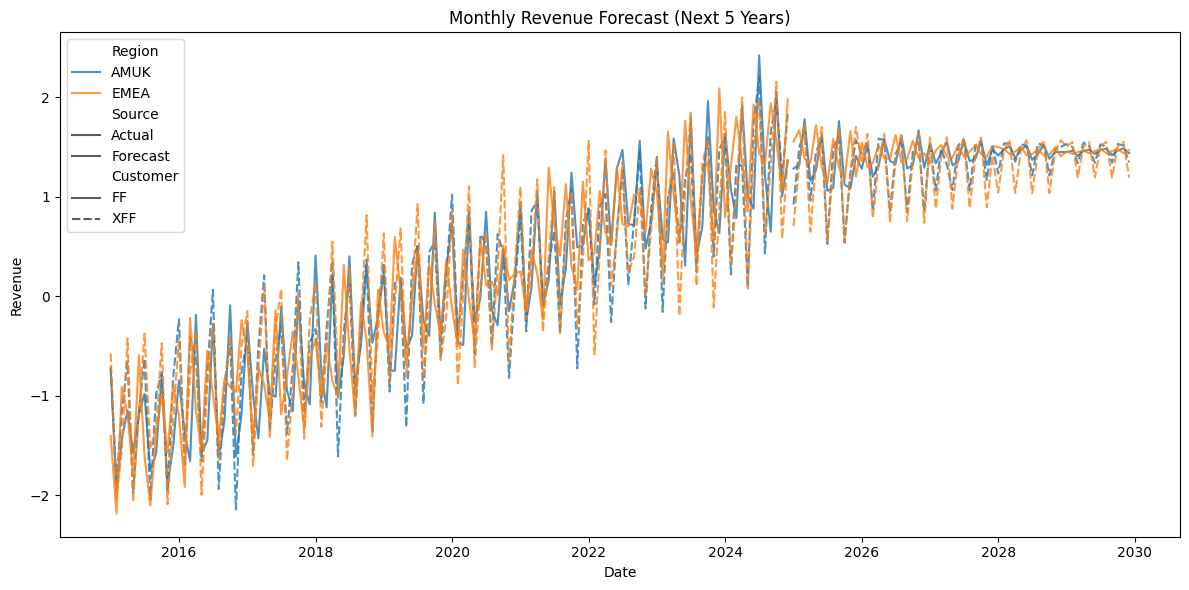

In [ ]:
import torch
torch.manual_seed(seed=42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model.load_state_dict(torch.load(f=save_path, weights_only=True))
model.eval()

in_window, out_window = 24, 12
forecast_horizon = 5 * 12

def forecast_entity(region, customer, data):
    region = torch.tensor(data=[region2idx[region]],
        dtype=torch.long).to(device)
    customer = torch.tensor(data=[customer2idx[customer]],
            dtype=torch.long).to(device)
    history = torch.tensor(data=data[-in_window:],
        dtype=torch.float32).unsqueeze(1).to(device)

    preds = []
    with torch.no_grad():
        for _ in range(forecast_horizon // out_window):
            memory = model.encode(region=region, customer=customer, src_feats=history)
            dec_input = history[-out_window:].clone()
            out = model.decode(region=region, customer=customer,
                tgt_feats=dec_input, memory=memory)
            pred = out[-out_window:]
            preds.append(pred.squeeze(1).cpu().numpy())
            history = torch.cat(tensors=[history, pred], dim=0)
    preds = np.concatenate(preds, axis=0)[:forecast_horizon]
    return preds

dfs_forecast = []
for region in regions:
    for customer in customers:
        df_entity = df_scaled[(df_scaled['Region']==region)
            &(df_scaled['Customer']==customer)].copy()
        df_entity.sort_values(by='Date', inplace=True)
        data = df_entity[features].values.astype(np.float32)

        preds = forecast_entity(region=region, customer=customer, data=data)
        # preds = scalers[(region, customer)].inverse_transform(X=preds)
        forecast_dates = pd.date_range(start=df_entity['Date'].iloc[-1]\
            + pd.offsets.MonthBegin(), periods=forecast_horizon, freq='MS')
        df_temp = pd.DataFrame({
            'Date': forecast_dates,
            'Region': region,
            'Customer': customer,
            'Volume': preds[:, 0],
            'Revenue': preds[:, 1]
        })
        dfs_forecast.append(df_temp)

df_forecast = pd.concat(dfs_forecast, ignore_index=True)
df_forecast = pd.concat([df_scaled.assign(Source='Actual'),
    df_forecast.assign(Source='Forecast')])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_forecast, x='Date', y='Volume', hue='Region', style='Customer',
    size='Source', sizes={'Actual': 1.5, 'Forecast': 1.5}, alpha=0.8)
plt.title('Monthly Volume Forecast (Next 5 Years)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_forecast, x='Date', y='Revenue', hue='Region', style='Customer',
    size='Source', sizes={'Actual': 1.5, 'Forecast': 1.5}, alpha=0.8)
plt.title('Monthly Revenue Forecast (Next 5 Years)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()